## Table of contents

### 1. EDA

 - Multicollinearity and correlations
 - Check data distribuitions

### 2. Preprocessing

 - Train test split
 - One-hot-encoding
 - Scaling
 - Craete lists to add models and reports
 
### 3. Applying different models

 - LR on all features
 - Compare with StatsModels
 - LR with the coefficients that have p-values < 0.05
 - Random Forests
 - XGBoost
 - Gradient Boosting
 
### 4. Correcting class imbalance with rejected dataset

 - Random Forests
 - LR 
 - Gradient Boosting
 - XGBoost
 
### 5. Correcting class imbalance through resampling

 - Random Forests
 - Gradient Boosting
 - XGBoost
 - LR 
 
### 6. Models comparison
 
### 7. Further exploration of the selected Logistic Regression model (lr4)
 
 - Cross-validated log loss and AUC
 - Threshold variation
 - ROC-AUC visualization
  
### 8. Making predictions with lr4 model
 
### 9. Checking lr4 model's calibation
 - Check model's calibration of training and testing set
 - Cross-validate calibration
 - Plot cross-validated calibration

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
import random
import seaborn as sns
from sklearn_pandas.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from functions import (ohe, logireg, gb, xgb, rf, predict_probability_and_class, check_calibration,
                       keep_states_drop, preprocess, scale_columns, parse_reports)
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, make_scorer, 
recall_score, accuracy_score, precision_score, confusion_matrix)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
import pickle
import scikitplot as skplt
from plr.predict import predict_p

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
#had to install xgboost
#!pip install xgboost

### Load data

In [314]:
df_approved = pd.read_csv('data/pf_approved_loan_data_nov.csv', index_col=False)
df_rejected = pd.read_csv('data/pf_rejected_loan_data_nov.csv', index_col=False)

# 1. EDA

In [315]:
len(df_approved)

4145

In [316]:
len(df_rejected)

2927

In [317]:
#How many loans were returned?

df_approved['status'].value_counts()

1    3317
0     828
Name: status, dtype: int64

### 75% of application from the approved set were paid pack

In [318]:
#Are the 2 dataframes's columns similar?

df_rejected.columns == df_approved.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [319]:
#What are the columns in the dataframes?
df_approved.columns

Index(['Unnamed: 0', 'monthly_income', 'gig_economy_weekly_income',
       'atm_check_deposits_weekly_income', 'direct_deposit_weekly_income',
       'government_aid_weekly_income', 'frequency_heuristic_weekly_income',
       'large_deposits_weekly_income', 'income_length', 'payrolls_per_month',
       'income_sources', 'days_since_most_recent_payroll',
       'days_until_next_payroll', 'bank_balance', 'overdraft_transactions',
       'nsf_transactions', 'return_transactions', 'reverse_transactions',
       'length_of_transaction_history', 'mortgage', 'auto_loan',
       'student_loan', 'traditional_single_payment', 'installment_loan',
       'predatory_installment_loan', 'title_loan', 'pay_advances',
       'total_loan_payments', 'no_of_other_active_loans',
       'traditional_single_payment_mean', 'traditional_single_payment_trend',
       'loan_amount', 'loan_requested', 'loan_borrowed_inc',
       'loan_outstanding_inc', 'state', 'loan_id', 'status'],
      dtype='object')

In [320]:
df_approved.shape

(4145, 38)

In [321]:
df_approved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 38 columns):
Unnamed: 0                           4145 non-null int64
monthly_income                       4145 non-null float64
gig_economy_weekly_income            4145 non-null float64
atm_check_deposits_weekly_income     4145 non-null float64
direct_deposit_weekly_income         4145 non-null float64
government_aid_weekly_income         4145 non-null float64
frequency_heuristic_weekly_income    4145 non-null float64
large_deposits_weekly_income         4145 non-null float64
income_length                        4145 non-null int64
payrolls_per_month                   4145 non-null float64
income_sources                       4145 non-null int64
days_since_most_recent_payroll       4145 non-null int64
days_until_next_payroll              4145 non-null int64
bank_balance                         4145 non-null float64
overdraft_transactions               4145 non-null int64
nsf_transactions    

There are no null values and all essential data is numeric, which helps a lot with the analysis process.

In [322]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 38 columns):
Unnamed: 0                           2927 non-null int64
monthly_income                       2927 non-null float64
gig_economy_weekly_income            2927 non-null float64
atm_check_deposits_weekly_income     2927 non-null float64
direct_deposit_weekly_income         2927 non-null float64
government_aid_weekly_income         2927 non-null float64
frequency_heuristic_weekly_income    2927 non-null float64
large_deposits_weekly_income         2927 non-null float64
income_length                        2927 non-null int64
payrolls_per_month                   2927 non-null float64
income_sources                       2927 non-null int64
days_since_most_recent_payroll       2927 non-null int64
days_until_next_payroll              2927 non-null int64
bank_balance                         2927 non-null float64
overdraft_transactions               2927 non-null int64
nsf_transactions    

There are null values only in 'state' column. Essential data is numeric

In [323]:
df_rejected['state'].value_counts()

"WA"    1531
"CA"     657
"UT"     506
"ID"     130
"TX"       3
"AZ"       2
"CO"       1
"MA"       1
"OK"       1
"WI"       1
"MT"       1
"TN"       1
Name: state, dtype: int64

In [324]:
set(list(df_rejected.state.values))

{'"AZ"',
 '"CA"',
 '"CO"',
 '"ID"',
 '"MA"',
 '"MT"',
 '"OK"',
 '"TN"',
 '"TX"',
 '"UT"',
 '"WA"',
 '"WI"',
 nan}

I decided to drop states that do not apperar in approved datasets and rejected dataset together. The idea is to be able to test the rejected dataset on the model created with approved application. I will also frop rows in rejected application where state is not specified.

In [325]:
df_approved['state'].value_counts()

"WA"    2334
"CA"    1131
"UT"     569
"ID"     108
"KS"       1
"GA"       1
"FL"       1
Name: state, dtype: int64

### Multicollinearity and correlations

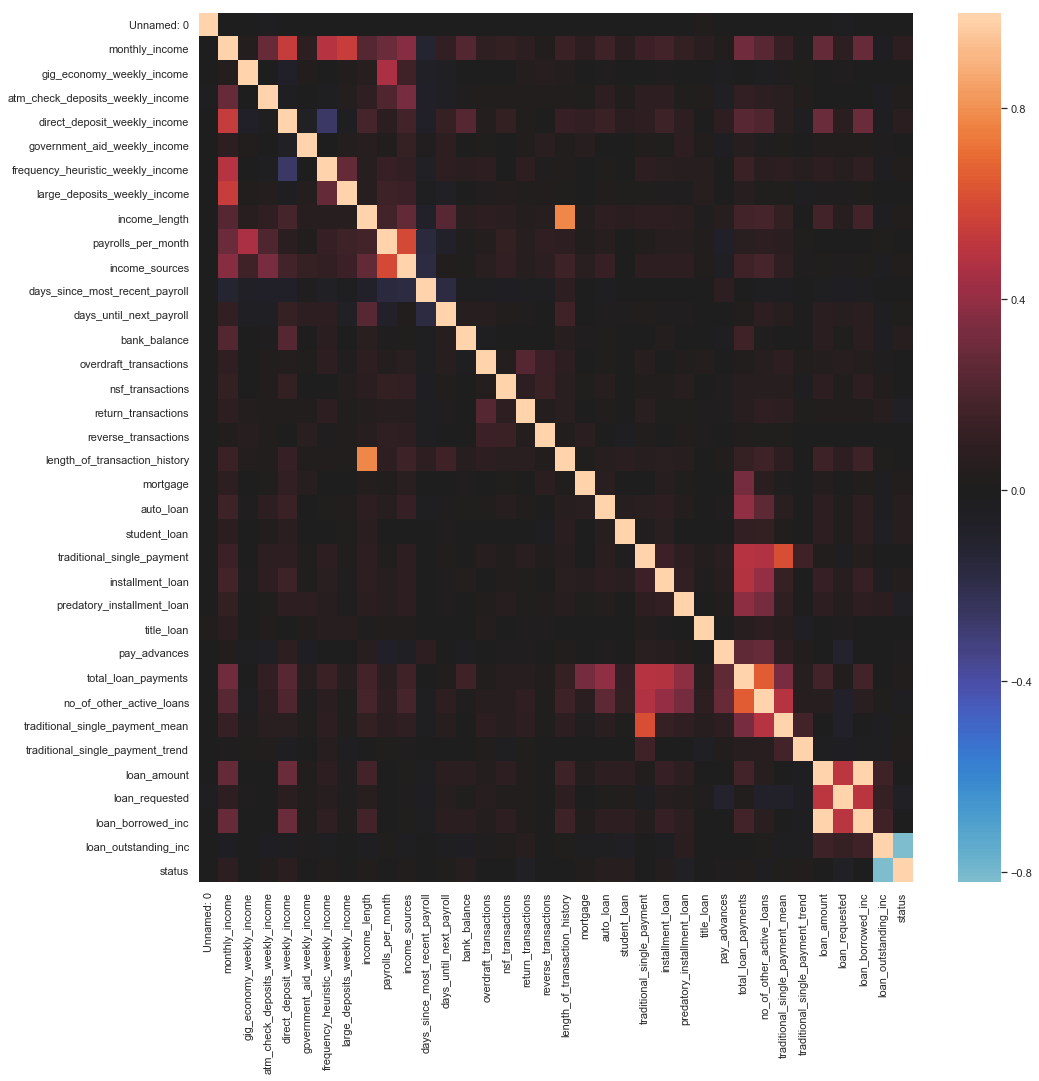

In [326]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_approved.corr(), center=0);

It is clear that there is some data that reflects event after granting the loan ('loan_amount', 'loan_borrowed', etc.).

There is also hight correlations between length of income and length of transaction history, which asre clearly connected.

In [327]:
#search where correlation is greater than 0.7
correlations = df_approved.corr().applymap(lambda x: 'yes' if (abs(x) > 0.7) else x)
dfs = []
for name in correlations.columns:
    if len(correlations.loc[correlations[name]=='yes']) > 1:
        dfs.append(correlations.loc[correlations[name]=='yes'])
len(dfs)  #6      
# I checked all dfs to see where are the correlations
dfs[5].T

,loan_outstanding_inc,status
Unnamed: 0,0.00410053,-0.00551489
monthly_income,-0.0433074,0.0808281
gig_economy_weekly_income,0.00774372,0.00616934
atm_check_deposits_weekly_income,-0.0450395,0.0376887
direct_deposit_weekly_income,-0.0320597,0.071408
government_aid_weekly_income,0.0116768,0.0034434
frequency_heuristic_weekly_income,-0.0185993,0.0277338
large_deposits_weekly_income,0.00704523,-0.000496234
income_length,-0.0255188,0.0355449
payrolls_per_month,0.0246747,-0.00298115


Apart from obvious correlation between features that describe loan after it was granted, the high correlation between `income_length` and `length_of_transaction_history` was confirmed.

### Check data distributions

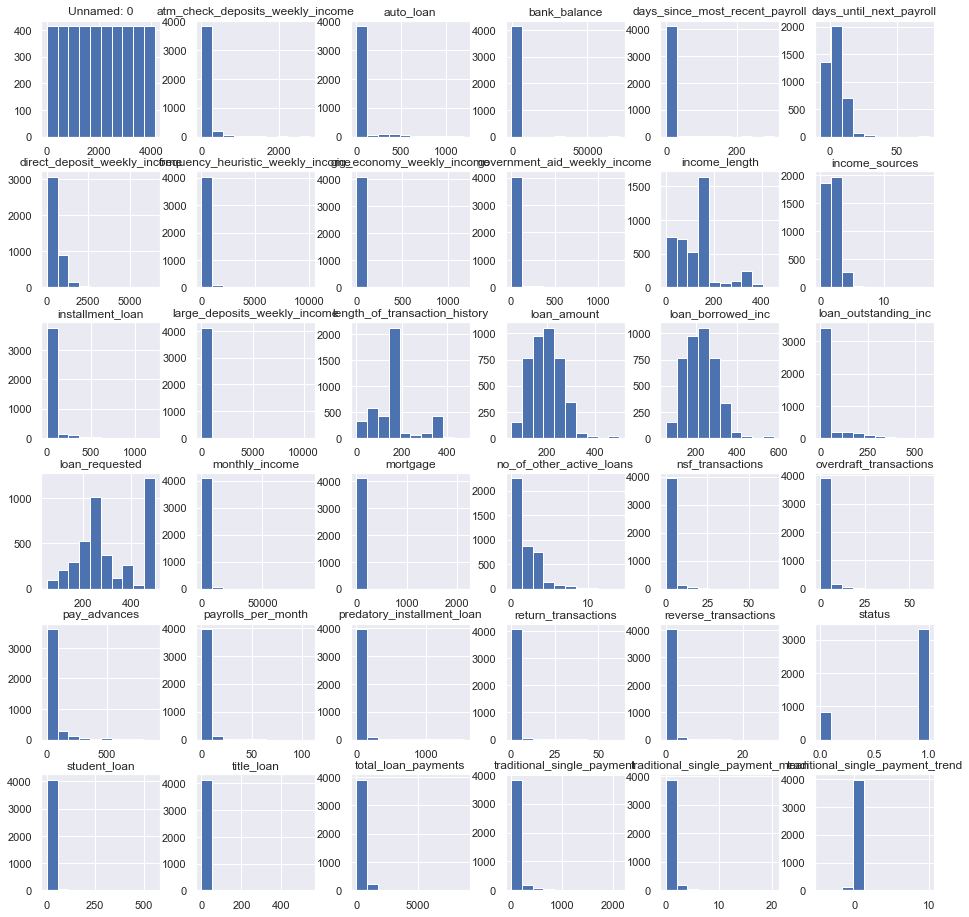

In [328]:
df_approved.hist();

Distribution is a bit confusing because of the scale of many variables. Some seem to have only 0 values, but it is not the case, as small values are not seen in the histograms.

# 2. Preprocessing

1. Drop `Unnamed: 0`, `loan_id` columns
2. Drop columns asocciated with granting the loan: `loan_amount`, `loan_borrowed_inc`, `loan_outstanding_inc`
3. Drop `length_of_transaction_history` because of correlation with `income_length`
2. Leave only states: 'WA', 'CA', 'UT', 'ID'

In [329]:
df_approved = preprocess(df_approved)
df_rejected = preprocess(df_rejected)

### Train test split
I will work mainly with approved loans dataset

In [330]:
random.seed(113)
y = df_approved['status']
X = df_approved.drop(['status'], axis=1)

#to maintain time order of the appointment date, shuffle is set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### One-hot-encoding

In [331]:
X_train = ohe(X_train, 'state')
X_test = ohe(X_test, 'state')

In [332]:
#reset indexes of y-values too (Xs were reset during ohe)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [333]:
#rejected dataset one-hot-encoding
df_rejected = ohe(df_rejected, 'state')

### Scaling

Without scaling I could not get consistent coefficient among Logistic Regression model from Sklearn and StatsModels.

In [334]:
#scale X_train
X_train_scaled, ss = scale_columns(X_train)

In [335]:
#scale X_test
X_test_scaled, ss = scale_columns(X_test, ss)

### Create lists to add models and reports

In [336]:
models = []
reports = []

# 3. Trying different models

### Logistic Regression on all the features

In [337]:
lr1, report_lr1 = logireg(X_train_scaled, X_test_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.34      0.14      0.20       168
           1       0.81      0.93      0.87       661

    accuracy                           0.77       829
   macro avg       0.58      0.54      0.53       829
weighted avg       0.72      0.77      0.73       829
 CV AUC score: 0.5643002742636855

Each Cross Validated AUC: 
 [0.54577621 0.5394385  0.64193405 0.5704775  0.52387511]

Overall Classifier AUC: 0.56 (+/- 0.08)



In [338]:
models.append(lr1)
reports.append(report_lr1)

In [339]:
#extract coefficients
coef = list(lr1.coef_[0])
coef

[0.13245043309482452,
 0.0502661224588125,
 0.08099235589778679,
 0.14060804316836772,
 0.007214009471858958,
 0.0764284095701796,
 -0.10119488262933247,
 -0.017881522933995305,
 -0.01661172011598022,
 0.07126103029629344,
 0.026724847620957125,
 0.0485440483908001,
 0.924860123930305,
 -0.02576055494250816,
 -0.02844984347363296,
 -0.05537444418843557,
 -0.013472958638310294,
 0.14506662956089786,
 0.1658651548274136,
 0.19117028561428093,
 -0.09609228699953849,
 0.15601606018188144,
 -0.12123362302876707,
 0.037832353256849006,
 0.17429611213653956,
 -0.10635058592119309,
 -0.05243486849358832,
 0.32337052314418296,
 0.09881449992034341,
 -0.5699723357580009,
 1.6615595475735774,
 1.1305709640629626,
 1.9864146411176826]

In [340]:
feature_names = X_test.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [341]:
features

,name,coef
0,monthly_income,0.132450
1,gig_economy_weekly_income,0.050266
2,atm_check_deposits_weekly_income,0.080992
3,direct_deposit_weekly_income,0.140608
4,government_aid_weekly_income,0.007214
5,frequency_heuristic_weekly_income,0.076428
6,large_deposits_weekly_income,-0.101195
7,income_length,-0.017882
8,payrolls_per_month,-0.016612
9,income_sources,0.071261


### Compare with StatsModels model

In [342]:
logit_model=sm.Logit(y_train, X_train_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.499729
         Iterations 20
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3281
Method:                           MLE   Df Model:                           31
Date:                Sun, 07 Jul 2019   Pseudo R-squ.:               -0.001677
Time:                        13:42:04   Log-Likelihood:                -1655.6
converged:                       True   LL-Null:                       -1652.8
                                        LLR p-value:                     1.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
monthly_income                        0.1324        nan      

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### Logistic Regression with the coefficients that have p-values < 0.05

In [343]:
X_train_mod = X_train[['bank_balance', 'auto_loan', 'student_loan',
                                     'installment_loan', 'pay_advances', 'traditional_single_payment_mean', 
                                    'loan_requested', 'state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]
X_test_mod = X_test[['bank_balance', 'auto_loan', 'student_loan',
                                     'installment_loan', 'pay_advances', 'traditional_single_payment_mean', 
                                    'loan_requested', 'state_\"ID\"', 'state_\"UT\"', 'state_\"WA\"']]

In [344]:
#fit and transform train
X_train_mod_scaled, ss = scale_columns(X_train_mod)

In [345]:
#transform test set
X_test_mod_scaled, ss = scale_columns(X_test_mod, ss)

In [346]:
lr2, report_lr2 = logireg(X_train_mod_scaled, X_test_mod_scaled, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.30      0.10      0.14       168
           1       0.80      0.94      0.87       661

    accuracy                           0.77       829
   macro avg       0.55      0.52      0.51       829
weighted avg       0.70      0.77      0.72       829
 CV AUC score: 0.5989352178452938

Each Cross Validated AUC: 
 [0.58911986 0.52295009 0.67702763 0.66368228 0.54189624]

Overall Classifier AUC: 0.60 (+/- 0.12)



In [347]:
models.append(lr2)
reports.append(report_lr2)

In [348]:
#extract coefficients
coef = list(lr2.coef_[0])
coef

[1.0654163783781356,
 0.15150712815377218,
 0.1988256948099143,
 0.1306291128597754,
 0.13591133561636545,
 0.21268101032199657,
 -0.5512368053837564,
 1.555193815006712,
 1.0702879735216364,
 1.9485383919775054]

In [349]:
feature_names = X_test_mod.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [350]:
features

,name,coef
0,bank_balance,1.065416
1,auto_loan,0.151507
2,student_loan,0.198826
3,installment_loan,0.130629
4,pay_advances,0.135911
5,traditional_single_payment_mean,0.212681
6,loan_requested,-0.551237
7,"state_""ID""",1.555194
8,"state_""UT""",1.070288
9,"state_""WA""",1.948538


In [351]:
logit_model=sm.Logit(y_train, X_train_mod_scaled, random_state=113)
result=logit_model.fit(maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.508693
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                 3313
Model:                          Logit   Df Residuals:                     3303
Method:                           MLE   Df Model:                            9
Date:                Sun, 07 Jul 2019   Pseudo R-squ.:                -0.01964
Time:                        13:42:05   Log-Likelihood:                -1685.3
converged:                       True   LL-Null:                       -1652.8
                                        LLR p-value:                     1.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
bank_balance                        1.0653      0.185      5.751  

### Random forests

In [352]:
rfc1, report_rfc1 = rf(X_train, X_test, y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.47      0.04      0.08       168
           1       0.80      0.99      0.89       661

    accuracy                           0.80       829
   macro avg       0.63      0.51      0.48       829
weighted avg       0.73      0.80      0.72       829
 CV AUC score: 0.5870173377455956

Each Cross Validated AUC: 
 [0.55340557 0.5298574  0.64739305 0.56955923 0.63487144]

Overall Classifier AUC: 0.59 (+/- 0.09)



In [353]:
models.append(rfc1)
reports.append(report_rfc1)

### XG Boost

In [354]:
xgb1, report_xgb1= xgb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.59      0.08      0.14       168
           1       0.81      0.99      0.89       661

    accuracy                           0.80       829
   macro avg       0.70      0.53      0.51       829
weighted avg       0.76      0.80      0.74       829
 CV AUC score: 0.5739310600273166

Each Cross Validated AUC: 
 [0.55042017 0.4741533  0.65775401 0.52502296 0.66230487]

Overall Classifier AUC: 0.57 (+/- 0.15)



In [355]:
models.append(xgb1)
reports.append(report_xgb1)

### Gradient Boosting

In [356]:
gb1, report_gb1 = gb(X_train, X_test, y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.67      0.04      0.07       168
           1       0.80      1.00      0.89       661

    accuracy                           0.80       829
   macro avg       0.73      0.52      0.48       829
weighted avg       0.77      0.80      0.72       829
 CV AUC score: 0.5727789941552958

Each Cross Validated AUC: 
 [0.62361787 0.49643494 0.63502674 0.52157943 0.587236  ]

Overall Classifier AUC: 0.57 (+/- 0.11)



In [357]:
models.append(gb1)
reports.append(report_gb1)

### Conclusion after trying different models: it seems that all models fail to perform on 0 class because of the class imbalance. Next step: correct class imbalance. Best model so far: random forests

# 4. Correcting class imbalance with rejected dataset

The current training set has 2649 class 1 values and 664 class 0 values. To correct class imbalance I will treat the rejected applications subset as class 0. I will randomly pick 2000 rejected applications and add them to the training set. I will then test the new model (random forest as it seems to have the best performance) on the original testing set that has true labels.

In [358]:
# Get random 2000 values from rejected dataset 

rejected_subset = df_rejected.sample(n=2000)

In [359]:
len(rejected_subset)

2000

In [360]:
# Isolate target column

y_subset_0 = rejected_subset['status']
X_subset_0 = rejected_subset.drop('status', axis=1)

In [361]:
# Doublecheck if the columns correspond
X_train.columns == X_subset_0.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [362]:
new_X_train = X_train.append(X_subset_0)
new_X_train = new_X_train.reset_index(drop=True)

In [363]:
new_y_train = y_train.append(y_subset_0)
new_y_train = new_y_train.reset_index(drop=True)

### Train random forests on the new training set

In [364]:
rfc2, report_rfc2 = rf(new_X_train, X_test, new_y_train, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.26      0.39      0.31       168
           1       0.82      0.71      0.76       661

    accuracy                           0.65       829
   macro avg       0.54      0.55      0.54       829
weighted avg       0.71      0.65      0.67       829
 CV AUC score: 0.5870173377455956

Each Cross Validated AUC: 
 [0.55340557 0.5298574  0.64739305 0.56955923 0.63487144]

Overall Classifier AUC: 0.59 (+/- 0.09)



In [365]:
models.append(rfc2)
reports.append(report_rfc2)

### Try logistic regression on my new training set

In [366]:
#scale the new dataset
new_X_train_scaled, ss2 = scale_columns(new_X_train)
new_X_test_scaled, ss2 = scale_columns(X_test, ss2)

In [367]:
#apply logistic regression

lr3, report_lr3 = logireg(new_X_train_scaled, new_X_test_scaled, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.26      0.48      0.34       168
           1       0.83      0.66      0.74       661

    accuracy                           0.62       829
   macro avg       0.55      0.57      0.54       829
weighted avg       0.72      0.62      0.66       829
 CV AUC score: 0.5649413803508934

Each Cross Validated AUC: 
 [0.54599735 0.5394385  0.64193405 0.57346189 0.52387511]

Overall Classifier AUC: 0.56 (+/- 0.08)



In [368]:
models.append(lr3)
reports.append(report_lr3)

### Try Gradient Boosting on my new training set

In [369]:
gb2, report_gb2 = gb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.26      0.36      0.30       168
           1       0.82      0.74      0.78       661

    accuracy                           0.66       829
   macro avg       0.54      0.55      0.54       829
weighted avg       0.71      0.66      0.68       829
 CV AUC score: 0.5727789941552958

Each Cross Validated AUC: 
 [0.62361787 0.49643494 0.63502674 0.52157943 0.587236  ]

Overall Classifier AUC: 0.57 (+/- 0.11)



In [370]:
models.append(gb2)
reports.append(report_gb2)

### Try XGBoost  regression on my new training set

In [371]:
xgb2, report_xgb2 = xgb(new_X_train, X_test, new_y_train, y_test)

Report:
              precision    recall  f1-score   support

           0       0.27      0.38      0.31       168
           1       0.82      0.74      0.78       661

    accuracy                           0.67       829
   macro avg       0.55      0.56      0.55       829
weighted avg       0.71      0.67      0.69       829
 CV AUC score: 0.5739310600273166

Each Cross Validated AUC: 
 [0.55042017 0.4741533  0.65775401 0.52502296 0.66230487]

Overall Classifier AUC: 0.57 (+/- 0.15)



In [372]:
models.append(xgb2)
reports.append(report_xgb2)

# 5. Correcting class imbalance with Sklearn resample

In [373]:
training_set = X_train.copy()

In [374]:
training_set['status'] = y_train

In [375]:
training_set_0 = training_set.loc[training_set.status == 0]

In [376]:
training_set_0.status.value_counts()

0    659
Name: status, dtype: int64

In [377]:
training_set_0_upsampled = resample(training_set_0, replace=True, n_samples=2000, random_state=0)

In [378]:
len(training_set_0_upsampled)

2000

In [379]:
y_training_set_0_upsampled = training_set_0_upsampled['status']
X_training_set_0_upsampled = training_set_0_upsampled.drop('status', axis=1)

In [380]:
new_X_train_upsampled = X_train.append(X_training_set_0_upsampled)
new_y_train_upsampled = y_train.append(y_training_set_0_upsampled)

In [381]:
new_X_train_upsampled = new_X_train_upsampled.reset_index(drop=True)
new_y_train_upsampled = new_y_train_upsampled.reset_index(drop=True)

### Apply random forest

In [382]:
rf3, report_rf3 = rf(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=113,
                       verbose=0, warm_start=False)
Report:
              precision    recall  f1-score   support

           0       0.31      0.11      0.17       168
           1       0.81      0.93      0.87       661

    accuracy                           0.77       829
   macro avg       0.56      0.52      0.52       829
weighted avg       0.70      0.77      0.72       829
 CV AUC score: 0.5870173377455956

Each Cross Validated AUC: 
 [0.55340557 0.5298574  0.64739305 0.56955923 0.63487144]

Overall Classifier AUC: 0.59 (+/- 0.09)



### Gradient boosting

In [383]:
gb3, report_gb3 = gb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.29      0.54      0.38       168
           1       0.85      0.67      0.75       661

    accuracy                           0.64       829
   macro avg       0.57      0.60      0.56       829
weighted avg       0.74      0.64      0.67       829
 CV AUC score: 0.5727789941552958

Each Cross Validated AUC: 
 [0.62361787 0.49643494 0.63502674 0.52157943 0.587236  ]

Overall Classifier AUC: 0.57 (+/- 0.11)



### XGBoost

In [384]:
xgb3, report_xgb3 = xgb(new_X_train_upsampled, X_test, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.30      0.54      0.38       168
           1       0.85      0.68      0.75       661

    accuracy                           0.65       829
   macro avg       0.57      0.61      0.57       829
weighted avg       0.74      0.65      0.68       829
 CV AUC score: 0.5739310600273166

Each Cross Validated AUC: 
 [0.55042017 0.4741533  0.65775401 0.52502296 0.66230487]

Overall Classifier AUC: 0.57 (+/- 0.15)



### Logistic regression

In [385]:
# Scaling
#train set
new_X_train_upsampled_scaled, ss3 = scale_columns(new_X_train_upsampled)
new_X_test_upsampled_scaled, ss3 = scale_columns(X_test, ss3)

In [386]:
lr4, report_lr4 = logireg(new_X_train_upsampled_scaled, new_X_test_upsampled_scaled, new_y_train_upsampled, y_test)

Report:
              precision    recall  f1-score   support

           0       0.26      0.58      0.36       168
           1       0.85      0.59      0.69       661

    accuracy                           0.59       829
   macro avg       0.55      0.58      0.53       829
weighted avg       0.73      0.59      0.63       829
 CV AUC score: 0.5652168624445573

Each Cross Validated AUC: 
 [0.54599735 0.5394385  0.64193405 0.5748393  0.52387511]

Overall Classifier AUC: 0.57 (+/- 0.08)



In [387]:
models.append(rf3)
models.append(gb3)
models.append(xgb3)
models.append(lr4)

reports.append(report_rf3)
reports.append(report_gb3)
reports.append(report_xgb3)
reports.append(report_lr4)

# 6. Models comparison

In [388]:
df_reports = parse_reports(reports)

In [389]:
df_reports['model'] = ['Logistic regression',
                      'Logistic Regression limited features',
                      'Random forest',
                      'XGBoost',
                      'Gradient boosting',
                      'Random forest with data from rejected dataset',
                      'Logistic regression with data from rejected dataset',
                      'Gradient Boosting with data from rejected dataset',
                      'XG Boost with data from rejected dataset',
                      'Random forest with resampled data',
                      'Gradient Boosting with resampled data',
                      'XG Boost with resampled data',
                      'Logistic regression with resampled data']

In [390]:
df_reports

,0.0,1.0,accuracy,CV_AUC_score,model
0,"{'precision': 0.34, 'recall': 0.14, 'f1': 0.2}","{'precision': 0.81, 'recall': 0.93, 'f1': 0.87}",0.77,0.564300,Logistic regression
1,"{'precision': 0.3, 'recall': 0.1, 'f1': 0.14}","{'precision': 0.8, 'recall': 0.94, 'f1': 0.87}",0.77,0.598935,Logistic Regression limited features
2,"{'precision': 0.47, 'recall': 0.04, 'f1': 0.08}","{'precision': 0.8, 'recall': 0.99, 'f1': 0.89}",0.80,0.587017,Random forest
3,"{'precision': 0.59, 'recall': 0.08, 'f1': 0.14}","{'precision': 0.81, 'recall': 0.99, 'f1': 0.89}",0.80,0.573931,XGBoost
4,"{'precision': 0.67, 'recall': 0.04, 'f1': 0.07}","{'precision': 0.8, 'recall': 1.0, 'f1': 0.89}",0.80,0.572779,Gradient boosting
5,"{'precision': 0.26, 'recall': 0.39, 'f1': 0.31}","{'precision': 0.82, 'recall': 0.71, 'f1': 0.76}",0.65,0.587017,Random forest with data from rejected dataset
6,"{'precision': 0.26, 'recall': 0.48, 'f1': 0.34}","{'precision': 0.83, 'recall': 0.66, 'f1': 0.74}",0.62,0.564941,Logistic regression with data from rejected da...
7,"{'precision': 0.26, 'recall': 0.36, 'f1': 0.3}","{'precision': 0.82, 'recall': 0.74, 'f1': 0.78}",0.66,0.572779,Gradient Boosting with data from rejected dataset
8,"{'precision': 0.27, 'recall': 0.38, 'f1': 0.31}","{'precision': 0.82, 'recall': 0.74, 'f1': 0.78}",0.67,0.573931,XG Boost with data from rejected dataset
9,"{'precision': 0.31, 'recall': 0.11, 'f1': 0.17}","{'precision': 0.81, 'recall': 0.93, 'f1': 0.87}",0.77,0.587017,Random forest with resampled data


Conclusion:

The models have quite similar AUC score, which in this case is the most important metric. Desicion tree based models have slightly better AUC, but they tend to overfit and are not calibrated as is logistic regression. For this reason the selected model has to be a logistic regression one. 

There are several logistic regression models. The ones with blanced classes seem to have better balanced predictive power for classes 0 and 1. There is no much difference betweer logistic regression upsampled from rejected daraset and the one upsampled using sklearn resample. I selected the last logistic regression upsampled with sklearn resample as a final model.

In [391]:
#pickle model
filename = 'lr_model.sav'
pickle.dump(lr4, open(filename, 'wb'))

#pickle standard scaler
filename = 'scaler.pkl'
pickle.dump(ss3, open(filename, 'wb'))

# 7. Further exploration of the selected Logistic Regression model (lr4)

### Cross-validated log loss and AUC

In [392]:
cv_log_loss = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='neg_log_loss')
print('Cross-validated log loss: ', cv_log_loss.mean())

Cross-validated log loss:  -0.5626890534925266


In [393]:
#interpretation: on average, the probability attributed to the right class across samples 𝑝≈0.63 
print('Average probability of labeling the class correctly: ', np.log(0.53))

Average probability of labeling the class correctly:  -0.6348782724359695


In [394]:
cv_roc_auc = cross_val_score(lr4, new_X_test_upsampled_scaled, y_test, cv=5, scoring='roc_auc')
print('Cross-validated AUC score: ', cv_roc_auc.mean())

Cross-validated AUC score:  0.5652168624445573


### Threshold variation

In [395]:
#this function allows to see predictions metrics with different thresholds for 0 class
res = predict_probability_and_class(lr4, new_X_test_upsampled_scaled, y_test, 0.25)

              precision    recall  f1-score   support

           0       0.22      0.96      0.35       168
           1       0.92      0.12      0.21       661

    accuracy                           0.29       829
   macro avg       0.57      0.54      0.28       829
weighted avg       0.78      0.29      0.24       829



In [396]:
res.head()

,status,0,1,pred_status
0,1,0.550631,0.449369,0
1,1,0.650233,0.349767,0
2,1,0.697926,0.302074,0
3,1,0.674350,0.325650,0
4,1,0.361588,0.638412,0


### ROC-AUC visualization

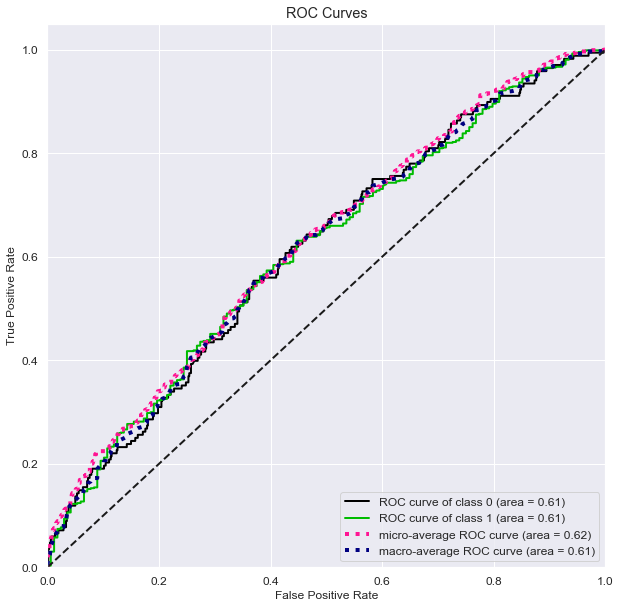

<Figure size 1152x1152 with 0 Axes>

In [397]:
y_true = res['status']
y_probas = lr4.predict_proba(new_X_test_upsampled_scaled)
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10,10))
plt.show();
plt.savefig('graphs/roc_auc.png')

### Model's coefficients

In [265]:
coef = lr4.coef_[0]

In [266]:
feature_names = new_X_test_upsampled_scaled.columns
features = pd.DataFrame()
features['name'] = feature_names
features['coef'] = coef

In [267]:
#sort by absolute value of coefficients
features['abs_coef'] = features['coef'].apply(lambda x: abs(x))
features.sort_values(by='abs_coef')

,name,coef,abs_coef
11,days_until_next_payroll,0.007077,0.007077
13,overdraft_transactions,-0.008098,0.008098
24,pay_advances,0.022451,0.022451
23,title_loan,-0.025129,0.025129
25,total_loan_payments,0.029413,0.029413
4,government_aid_weekly_income,0.036994,0.036994
14,nsf_transactions,-0.050480,0.050480
7,income_length,0.053863,0.053863
16,reverse_transactions,-0.063133,0.063133
2,atm_check_deposits_weekly_income,0.063685,0.063685


# 8. Making predictions with lr4 model

In [299]:
test_application = (0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 20, 1000, 5, 0, 1, 0, 1, 500, 100, 300,
                    3, 100, 0, 300, 2000, 4, 1, 1, 500, 0, 0, 0)

In [303]:
with open('lr_model.sav', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [304]:
prediction = predict_p(test_application, model, scaler)
print(prediction)

[[0.1617441 0.8382559]]


# 9. Checking lr4 model's calibation

### Check model's calibration of training and testing set

In [279]:
#check calibration of the test set

check_calibration(res)

[(1.0, '0 - 0.1', 19),
 (0.9333333333333333, '0.1 - 0.2', 30),
 (0.8983050847457628, '0.2 - 0.3', 59),
 (0.8583333333333333, '0.3 -0.4', 120),
 (0.8427947598253275, '0.4 - 0.5', 229),
 (0.7214611872146118, '0.5 - 0,6', 219),
 (0.71875, '0.6 - 0.7', 96),
 (0.65, '0.7 - 0.8', 40),
 (0.5882352941176471, '0.8 - 0.9', 17),
 (nan, '0.9 - 1', 0)]

In [280]:
#check calibration on train test:

res = predict_probability_and_class(lr4, new_X_train_upsampled_scaled, new_y_train_upsampled, 0.25)

              precision    recall  f1-score   support

           0       0.52      0.97      0.68      2657
           1       0.78      0.10      0.18      2656

    accuracy                           0.54      5313
   macro avg       0.65      0.54      0.43      5313
weighted avg       0.65      0.54      0.43      5313



In [281]:
check_calibration(res)

[(0.9578947368421052, '0 - 0.1', 95),
 (0.7697841726618705, '0.1 - 0.2', 139),
 (0.7490774907749077, '0.2 - 0.3', 271),
 (0.6598837209302325, '0.3 -0.4', 688),
 (0.5444444444444444, '0.4 - 0.5', 1440),
 (0.4617100371747212, '0.5 - 0,6', 1345),
 (0.3547589616810878, '0.6 - 0.7', 809),
 (0.20941176470588235, '0.7 - 0.8', 425),
 (0.19148936170212766, '0.8 - 0.9', 94),
 (0.2857142857142857, '0.9 - 1', 7)]

### Cross-validate calibration of lr4 model

In [282]:
#put back together test and train data
new_X_train_upsampled_scaled, new_X_test_upsampled_scaled, new_y_train_upsampled, y_test
X_n = pd.concat((new_X_train_upsampled_scaled, new_X_test_upsampled_scaled), join='inner')
y_n = pd.concat((new_y_train_upsampled, y_test), join='inner')

In [283]:
#split data into 5 splits, train model

kf = KFold(n_splits=5)
calibrations = []
for train_index, test_index in kf.split(X_n):
    print(train_index)
    print(test_index)

    new_X_train_upsampled_scaled, new_X_test_upsampled_scaled = X_n.iloc[train_index, :], X_n.iloc[test_index, :]
    
    y_train, y_test = y_n.iloc[train_index], y_n.iloc[test_index]
    lr5 = LogisticRegression(solver='lbfgs', fit_intercept = False, n_jobs=-1,  C = 1e12, random_state=113)
    lr5.fit(new_X_train_upsampled_scaled, y_train)
    res = predict_probability_and_class(lr5, new_X_test_upsampled_scaled, y_test, 0.25)
    # now do your calibration calculation on X_test, y_test
    calibrations.append(check_calibration(res))

[1229 1230 1231 ... 6139 6140 6141]
[   0    1    2 ... 1226 1227 1228]
              precision    recall  f1-score   support

           0       0.21      0.98      0.35       243
           1       0.94      0.10      0.17       986

    accuracy                           0.27      1229
   macro avg       0.58      0.54      0.26      1229
weighted avg       0.80      0.27      0.21      1229

[   0    1    2 ... 6139 6140 6141]
[1229 1230 1231 ... 2455 2456 2457]
              precision    recall  f1-score   support

           0       0.22      0.98      0.36       249
           1       0.94      0.11      0.19       980

    accuracy                           0.28      1229
   macro avg       0.58      0.54      0.27      1229
weighted avg       0.80      0.28      0.22      1229

[   0    1    2 ... 6139 6140 6141]
[2458 2459 2460 ... 3683 3684 3685]
              precision    recall  f1-score   support

           0       0.46      0.96      0.62       538
           1       0.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1228
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1228
   macro avg       0.50      0.43      0.46      1228
weighted avg       1.00      0.87      0.93      1228

[   0    1    2 ... 4911 4912 4913]
[4914 4915 4916 ... 6139 6140 6141]
              precision    recall  f1-score   support

           0       0.49      0.95      0.64       569
           1       0.77      0.13      0.22       659

    accuracy                           0.51      1228
   macro avg       0.63      0.54      0.43      1228
weighted avg       0.64      0.51      0.42      1228



In [284]:
calibrations

[[(1.0, '0 - 0.1', 32),
  (0.8717948717948718, '0.1 - 0.2', 39),
  (0.9428571428571428, '0.2 - 0.3', 70),
  (0.9102564102564102, '0.3 -0.4', 156),
  (0.84, '0.4 - 0.5', 325),
  (0.7709677419354839, '0.5 - 0,6', 310),
  (0.7405405405405405, '0.6 - 0.7', 185),
  (0.5647058823529412, '0.7 - 0.8', 85),
  (0.5217391304347826, '0.8 - 0.9', 23),
  (0.75, '0.9 - 1', 4)],
 [(0.9666666666666667, '0 - 0.1', 30),
  (0.9714285714285714, '0.1 - 0.2', 35),
  (0.8941176470588236, '0.2 - 0.3', 85),
  (0.875, '0.3 -0.4', 152),
  (0.8236914600550964, '0.4 - 0.5', 363),
  (0.7935483870967742, '0.5 - 0,6', 310),
  (0.6518987341772152, '0.6 - 0.7', 158),
  (0.6533333333333333, '0.7 - 0.8', 75),
  (0.5294117647058824, '0.8 - 0.9', 17),
  (0.5, '0.9 - 1', 4)],
 [(0.9428571428571428, '0 - 0.1', 35),
  (0.6666666666666666, '0.1 - 0.2', 33),
  (0.6071428571428571, '0.2 - 0.3', 84),
  (0.7336683417085427, '0.3 -0.4', 199),
  (0.5755813953488372, '0.4 - 0.5', 344),
  (0.5345911949685535, '0.5 - 0,6', 318),
  (0.36

In [285]:
ranges_0 = []
ranges_1 = []
ranges_2 = []
ranges_3 = []
ranges_4 = []
ranges_5 = []
ranges_6 = []
ranges_7 = []
ranges_8 = []
ranges_9 = []

for item in calibrations:
    for n, i in enumerate(item):
        if n == 0:
            ranges_0.append(i[0])
        elif n == 1:
            ranges_1.append(i[0])
        elif n == 2:
            ranges_2.append(i[0])
        elif n == 3:
            ranges_3.append(i[0])
        elif n == 4:
            ranges_4.append(i[0])
        elif n == 5:
            ranges_5.append(i[0])
        elif n == 6:
            ranges_6.append(i[0])
        elif n == 7:
            ranges_7.append(i[0])
        elif n == 8:
            ranges_8.append(i[0])
        elif n == 9:
            ranges_9.append(i[0])

In [286]:
#cross-validated average class label for P of default 0 - 0.1
avg_0 = np.array(ranges_0).mean()
avg_0

0.7735714285714287

In [287]:
#cross-validated average class label for P of default 0.1 - 0.2
avg_1 = np.array(ranges_1).mean()
avg_1

0.6570800627943485

In [288]:
#cross-validated average class label for P of default 0.2 - 0.3
avg_2 = np.array(ranges_2).mean()
avg_2

0.6260784313725491

In [289]:
#cross-validated average class label for P of default 0.3 - 0.4
avg_3 = np.array(ranges_3).mean()
avg_3

0.6312268108581068

In [290]:
#cross-validated average class label for P of default 0.4 - 0.5
avg_4 = np.array(ranges_4).mean()
avg_4

0.5578545710807867

In [291]:
#cross-validated average class label for P of default 0.5 - 0.6
avg_5 = np.array(ranges_5).mean()
avg_5

0.5130114289578684

In [292]:
#cross-validated average class label for P of default 0.6 - 0.7
avg_6 = np.array(ranges_6).mean()
avg_6

0.41634591945968014

In [293]:
#cross-validated average class label for P of default 0.7 - 0.8
avg_7 = np.array(ranges_7).mean()
avg_7

0.3729705590395777

In [294]:
#cross-validated average class label for P of default 0.8 - 0.9
avg_8 = np.array(ranges_8).mean()
avg_8

0.2839143895544488

In [295]:
#cross-validated average class label for P of default 0.9 - 1
avg_9 = np.array(ranges_9).mean()
avg_9

nan

### Plot cross-validated calibration

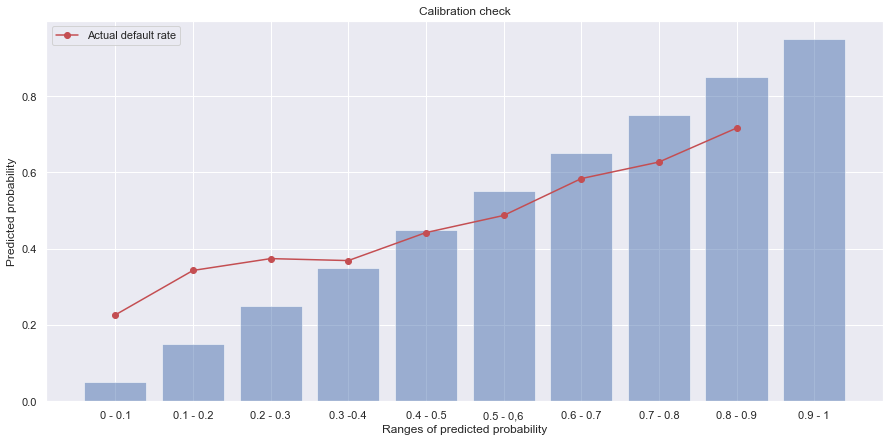

<Figure size 1152x1152 with 0 Axes>

In [296]:
ranges = ['0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 -0.4', '0.4 - 0.5', '0.5 - 0,6',
           '0.6 - 0.7', '0.7 - 0.8', '0.8 - 0.9', '0.9 - 1']
avg_ranges = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
means = [(1-avg_0), (1-avg_1), (1-avg_2), (1-avg_3), (1-avg_4), (1-avg_5), 
         (1-avg_6), (1-avg_7), (1-avg_8), (1-avg_9)]
plt.figure(figsize=(15, 7))
plt.bar(ranges, avg_ranges, align='center', alpha=0.5)
plt.plot(means, 'r', marker='o')
plt.legend(['Actual default rate'])
plt.ylabel('Predicted probability')
plt.xlabel('Ranges of predicted probability')
plt.title('Calibration check')

plt.show()
plt.savefig('graphs/calibration_check.png')

#### There are not a lot of observations in 0.9 - 1 range comparing to the other ranges, that might explain that predicted and actual probability don't match